In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，过去都当做历史信息

list1 = list(range(5,5+72+2000+300))+list(range(5+72+2000+600,5+72+2000+900))
x = df.iloc[:,list1]
y = df.iloc[:,5+72+2000+300:5+72+2000+600]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)


# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)




C:\Users\PINKPI~1\AppData\Local\Temp/ipykernel_14712/56431373.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['gender'] = LabelEncoder().fit_transform(x['gender'])
C:\Users\PINKPI~1\AppData\Local\Temp/ipykernel_14712/56431373.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
C:\Users\PINKPI~1\AppData\Local\Temp/ipykernel_14712/56431373.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [9]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=256,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l1(0.00001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




create model. feature_dim =2672, label_dim =300
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               684288    
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 300)               77100     
                                                                 
Total params: 827,180
Trainable params: 827,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.3915 - JI: 0.0304 - val_loss: 0.1134 - val_JI: 0.0275
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1172 - JI: 0.0323 - val_loss: 0.1092 - val_JI: 0.0393
Ep

110/110 [==============================] - 1s 8ms/step - loss: 0.0777 - JI: 0.1874 - val_loss: 0.0818 - val_JI: 0.1636
Epoch 57/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0775 - JI: 0.1894 - val_loss: 0.0816 - val_JI: 0.1606
Epoch 58/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0771 - JI: 0.1933 - val_loss: 0.0817 - val_JI: 0.1894
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0768 - JI: 0.1962 - val_loss: 0.0813 - val_JI: 0.1682
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0764 - JI: 0.1982 - val_loss: 0.0812 - val_JI: 0.1716
Epoch 61/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0762 - JI: 0.1995 - val_loss: 0.0810 - val_JI: 0.1869
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0766 - JI: 0.1991 - val_loss: 0.0808 - val_JI: 0.1679
Epoch 63/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0757 - JI: 

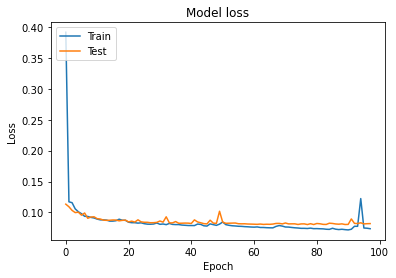

验证集上的最优结果是0.19790711998939514,对应训练轮次是88


0.19790711998939514

In [12]:
# 划分数据集 9:1
# 预测第二天用药，过去都当做历史信息
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

train_DNN(X_train,y_train,X_test,y_test)

create model. feature_dim =2072, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               530688    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 300)               77100     
                                                                 
Total params: 673,580
Trainable params: 673,580
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4191 - JI: 0.0297 - val_loss: 0.1357 - val_JI: 0.0202
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1385 - JI: 0.0191 - val_loss: 0.1404 - val_JI: 0.0408
Ep

110/110 [==============================] - 1s 7ms/step - loss: 0.0889 - JI: 0.1259 - val_loss: 0.0923 - val_JI: 0.1202
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0891 - JI: 0.1254 - val_loss: 0.0924 - val_JI: 0.1143
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0885 - JI: 0.1262 - val_loss: 0.0916 - val_JI: 0.1260
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0885 - JI: 0.1264 - val_loss: 0.0915 - val_JI: 0.1192
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0887 - JI: 0.1260 - val_loss: 0.0906 - val_JI: 0.1103
Epoch 61/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0879 - JI: 0.1283 - val_loss: 0.0908 - val_JI: 0.1156
Epoch 62/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0879 - JI: 0.1294 - val_loss: 0.0909 - val_JI: 0.0988
Epoch 63/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0880 - JI: 

110/110 [==============================] - 1s 7ms/step - loss: 0.0857 - JI: 0.1494 - val_loss: 0.0902 - val_JI: 0.1166
Epoch 119/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0849 - JI: 0.1498 - val_loss: 0.0889 - val_JI: 0.1271
Epoch 120/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0844 - JI: 0.1522 - val_loss: 0.0887 - val_JI: 0.1317
Epoch 121/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0842 - JI: 0.1529 - val_loss: 0.0898 - val_JI: 0.1334
Epoch 122/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0843 - JI: 0.1539 - val_loss: 0.0897 - val_JI: 0.1289
Epoch 123/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0836 - JI: 0.1562 - val_loss: 0.0892 - val_JI: 0.1350
Epoch 124/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0832 - JI: 0.1586 - val_loss: 0.0882 - val_JI: 0.1393
Epoch 125/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0828

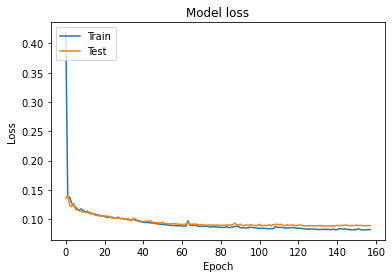

验证集上的最优结果是0.14969061315059662,对应训练轮次是156


0.14969061315059662

In [8]:
df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，不用历史用药
x = df.iloc[:,5:5+72+2000]
y = df.iloc[:,5+72+2000+300:5+72+2000+600]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)




create model. feature_dim =2072, label_dim =300
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               530688    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 300)               77100     
                                                                 
Total params: 673,580
Trainable params: 673,580
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4572 - JI: 0.0285 - val_loss: 0.1140 - val_JI: 0.0211
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1174 - JI: 0.0213 - val_loss: 0.1068 - val_JI: 0.0191
Ep

110/110 [==============================] - 1s 7ms/step - loss: 0.0849 - JI: 0.1335 - val_loss: 0.0893 - val_JI: 0.1039
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0841 - JI: 0.1392 - val_loss: 0.0891 - val_JI: 0.1331
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0856 - JI: 0.1318 - val_loss: 0.0888 - val_JI: 0.1260
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0841 - JI: 0.1389 - val_loss: 0.0902 - val_JI: 0.1144
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0842 - JI: 0.1388 - val_loss: 0.0886 - val_JI: 0.1092
Epoch 61/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0843 - JI: 0.1401 - val_loss: 0.0891 - val_JI: 0.1176
Epoch 62/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0835 - JI: 0.1432 - val_loss: 0.0889 - val_JI: 0.1175
Epoch 63/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0835 - JI: 

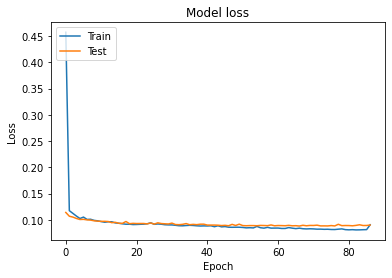

验证集上的最优结果是0.13610950112342834,对应训练轮次是74


0.13610950112342834

In [10]:
train_DNN(X_train,y_train,X_test,y_test)

create model. feature_dim =2372, label_dim =300
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               607488    
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.6168 - JI: 0.0337 - val_loss: 0.1140 - val_JI: 0.0361
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1178 - JI: 0.0374 - val_loss: 0.1063 - val_JI: 0.0412
Ep

110/110 [==============================] - 1s 7ms/step - loss: 0.0754 - JI: 0.2115 - val_loss: 0.0818 - val_JI: 0.1621
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0755 - JI: 0.2094 - val_loss: 0.0809 - val_JI: 0.1767
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0752 - JI: 0.2134 - val_loss: 0.0815 - val_JI: 0.1609
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0750 - JI: 0.2138 - val_loss: 0.0812 - val_JI: 0.1730
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0745 - JI: 0.2155 - val_loss: 0.0827 - val_JI: 0.1983
Epoch 61/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0755 - JI: 0.2108 - val_loss: 0.0819 - val_JI: 0.1847
Epoch 62/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0748 - JI: 0.2147 - val_loss: 0.0806 - val_JI: 0.1777
Epoch 63/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0743 - JI: 

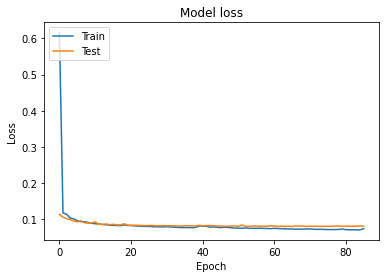

验证集上的最优结果是0.2075154185295105,对应训练轮次是84


0.2075154185295105

In [14]:
df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，第一天当做历史信息
x = df.iloc[:,5:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+300]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

train_DNN(X_train,y_train,X_test,y_test)